# Differential Learning in TensorFlow 2
This notebook implements the paper [*Differential Machine Learning*](https://arxiv.org/abs/2005.02347) by Brian Huge and Antoine Savine. The authors already provide notebooks [on their github page](https://github.com/differential-machine-learning) but using TensorFlow 1 code, and lots of low-level manual implementation. Here we aim to reproduce the results with high-level APIs (Keras, GradientTape) in TensorFlow 2. We will use the notations from the authors' notebook as much as possible to allow for easy comparison.

# Imports

In [1]:
import tensorflow as tf
print("Using TensorFlow version", tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler

Using TensorFlow version 2.2.0


# Part I: Code Functions

## Feedforward neural network in TensorFlow
Feedforward networks are easily defined in Keras with the [Sequential API](https://www.tensorflow.org/guide/keras/overview#sequential_model) so we don't need to write our own here!

## Explicit backpropagation and twin network
We will use the [Keras subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class) to define twin networks: given any "vanilla" network, its twin version will also return the sensitivities to inputs by AAD. 
In TensorFlow 2, getting the gradients is easily achieved using [tf.gradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape). 
We try to keep As we can see, it doesn't take much code and greatly reduces the risk of errors!

In [2]:
class TwinNetwork(tf.keras.Model):

    def __init__(self, vanilla_net):
        super(TwinNetwork, self).__init__()
        self.vanilla_net = vanilla_net

    def call(self, inputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            predictions = self.vanilla_net(inputs)
        derivs_predictions = tape.gradient(predictions, inputs) 
        return predictions, derivs_predictions

## Training Loop
By implementing TwinNetwork as a Keras model, we get an important benefit: the [API](https://www.tensorflow.org/guide/keras/train_and_evaluate) implements the training loop for us, and is flexible enough to combine multiple losses on multi-output networks like TwinNetwork. The only thing for us to implement is the weighted mean squared error used as loss function for the sensitivities. We sublass [Keras Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss) to implement this logic.

In [3]:
class WeightedMeanSquaredError(tf.keras.losses.Loss):
    
    def __init__(self, lambda_j):
        super(WeightedMeanSquaredError, self).__init__()
        self.lambda_j = tf.reshape(lambda_j, (1,-1))

    def call(self, y_true, y_pred):
        return tf.keras.losses.MSE(self.lambda_j*y_true, self.lambda_j*y_pred)

## Data Normalization
For convenience here we introduce a simple class for data pre-processing, inspired by [scikit's StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) but tailored to our needs.

In [4]:
from sklearn.preprocessing import StandardScaler

class TwinScaler():
    
    def __init__(self):
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        
    def fit(self, x, y):
        self.x_scaler.fit(x)
        self.y_scaler.fit(y)
        self.dy_dx_scale = self.x_scaler.scale_ / self.y_scaler.scale_
        
    def transform(self, x, y, dy_dx):
        x_scaled = self.x_scaler.transform(x)
        y_scaled = self.y_scaler.transform(y)
        dy_dx_scaled = dy_dx * self.dy_dx_scale
        return (x_scaled, y_scaled, dy_dx_scaled)
        
    def inverse_transform(self, y_scaled, dy_dx_scaled):
        y = self.y_scaler.inverse_transform(y_scaled)
        dy_dx = dy_dx_scaled / self.dy_dx_scale
        return (y, dy_dx)


We also implement helper functions to calculate the weights *lambda_j* in the loss on sensitivities, and the coefficients *alpha* and *beta* to combine the loss on prices and the loss on sensitivities

In [5]:
def calc_lambda_j(dy_dx_scaled):
    return 1.0/tf.math.sqrt(tf.reduce_mean(tf.square(dy_dx_scaled), axis=0))

def calc_alpha_beta(n, lambda_hyperparameter= 1):
    alpha = 1/(1+lambda_hyperparameter*n)
    beta = 1-alpha
    return [alpha, beta]

# Part II : Learning Pricing and Risk Functions from LSM samples

## Black & Scholes
The following code is taken from the [original notebook](https://github.com/differential-machine-learning) to generate the Black-Scholes call option example in 1 dimension. We don't modify it.

In [6]:
# helper analytics    
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
#
    
# main class
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, prices, deltas, vegas   

This gives us our training dataset:

In [7]:
bs = BlackScholes()
bs_sims = bs.trainingSet(8192, anti=True, seed=1234)

Normalize the data

In [8]:
bs_scaler = TwinScaler()
bs_scaler.fit(bs_sims[0], bs_sims[1])
bs_scaled = bs_scaler.transform(*bs_sims)

the BlackScholes class is built with NumPy that uses float64 by default, while TensorFlow uses float32. Matrix multiplication will throw if the two types are mixed up, so we explicitely cast to tf.float32

In [9]:
bs_scaled = list(map(lambda x: tf.cast(x, tf.float32), bs_scaled))

Calculate lambda_j, create the corresponding weighted MSE loss object, and calculate the relative weights of price loss and sensitivities loss:

In [10]:
lambda_j = calc_lambda_j(bs_scaled[-1])
weighted_mse = WeightedMeanSquaredError(lambda_j)

[alpha, beta] = calc_alpha_beta(bs_scaled[0].shape[1], lambda_hyperparameter= 1)

Now we can define a simple neural net, here with 4 hidden layers of size 20 and softplus activation.

In [11]:
vanilla_net = Sequential(
    [Dense(20, activation='softplus', input_shape=(1,)), 
     Dense(20, activation='softplus'), 
     Dense(20, activation='softplus'), 
     Dense(20, activation='softplus'), 
     Dense(1, activation=None)]
)

We then convert it to a twin network with a simple call:

In [12]:
twin_net = TwinNetwork(vanilla_net)

The compilation step lets use choose the optimizer and, more importantly, the loss for each head of the model (prices, sensitivities), as well as loss_weights the combine the losses. In our case they are alpha and beta calculated earlier.

In [13]:
twin_net.compile(optimizer="adam", loss=["mse", weighted_mse], loss_weights=[alpha, beta])

Define training hyperparameters:

In [14]:
EPOCHS = 100
BATCH_SIZE = 256
STEPS_PER_EPOCH = 16

We build the learning rate scheduler using a [Keras callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler):

In [15]:
lr_schedule_epochs = [0.0, 0.2, 0.6, 0.9, 1.0]
lr_schedule_rates = [1e-8, 0.1, 0.01, 1e-6, 1e-8]
lr_schedule_fn = lambda t: np.interp(t/(EPOCHS-1), lr_schedule_epochs, lr_schedule_rates)

lr_scheduler = LearningRateScheduler(lr_schedule_fn) 

We can now fit our model. To train on multiple outputs we simply pass them as a list.

In [16]:
hist = twin_net.fit(bs_scaled[0], [bs_scaled[1], bs_scaled[2]], \
                    batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[lr_scheduler])

Epoch 1/100
16/16 [==============================] - 0s 1ms/step - loss: 0.9736 - output_1_loss: 0.9822 - output_2_loss: 0.9650 - lr: 1.0000e-08
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 0.6738 - output_1_loss: 0.6585 - output_2_loss: 0.6891 - lr: 0.0051
Epoch 3/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2641 - output_1_loss: 0.2049 - output_2_loss: 0.3233 - lr: 0.0101
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 0.1594 - output_1_loss: 0.1143 - output_2_loss: 0.2044 - lr: 0.0152
Epoch 5/100
16/16 [==============================] - 0s 1ms/step - loss: 0.1370 - output_1_loss: 0.1063 - output_2_loss: 0.1677 - lr: 0.0202
Epoch 6/100
16/16 [==============================] - 0s 1ms/step - loss: 0.1283 - output_1_loss: 0.1067 - output_2_loss: 0.1500 - lr: 0.0253
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 0.1231 - output_1_loss: 0.1017 - output_2_loss: 0.1445 - lr: 0.0303
Epoch 8/1

Now we want to see how our network performs on the testing set. We'll need to scale our data, get the predictions, and de-scale the outputs: we put it all in a helper class *Pipeline*

In [17]:
# Helper class to scale, predict, unscale
class Pipeline():
    def __init__(self, twin_net, scaler):
        self.twin_net = twin_net
        self.scaler = scaler
        
    def predict(self, x):
        x_scaled = self.scaler.x_scaler.transform(x)
        y_scaled = self.twin_net.predict(x_scaled)
        y = self.scaler.inverse_transform(*y_scaled)
        return y

Create our prediction pipeline for the twin model:

In [18]:
pipe = Pipeline(twin_net, bs_scaler)

Initialize the test set:

In [19]:
bs_test= bs.testSet()

Get our predictions from the pipeline:

In [20]:
test_pred = pipe.predict(bs_test[0])

Plot our prediction of prices against closed-form prices:

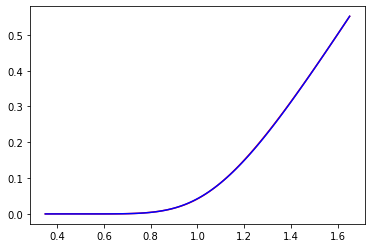

In [21]:
# prices predictions
plt.plot(bs_test[0], test_pred[0], 'r')
plt.plot(bs_test[0], bs_test[1], 'b')
plt.show()

Do the same for delta:

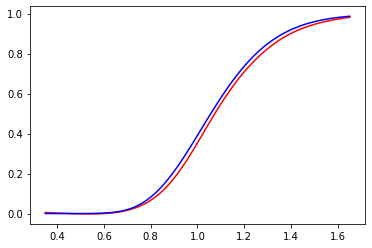

In [22]:
# Delta predictions
plt.plot(bs_test[0], test_pred[1], 'r')
plt.plot(bs_test[0], bs_test[2], 'b')
plt.show()

A very good fit!